# LSTM Model for Stock Price Prediction

## This NoteBook loads preprocessed data, defines an LSTM model using PyTorch, trains it, and evaluates its performance on stock price prediction.

## 1. Load Preprocessed Data

### Define Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import joblib

#### Load the preprocessed sequences and scaler from the preprocessing script.

In [63]:
path = '../data/'

X_train = np.load(path+'X_train.npy')
X_test = np.load(path+'X_test.npy')
y_train = np.load(path+'y_train.npy')
y_test = np.load(path+'y_test.npy')
scaler = joblib.load(path+'scaler.pkl')
features_to_scale = joblib.load(path+'features_to_scale.pkl')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (72, 60, 12)
y_train shape: (72,)
X_test shape: (19, 60, 12)
y_test shape: (19,)


### Define the LSTM model architecture and set up the device (CPU/GPU).

#### Check for GPU availabiliy

In [64]:
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


#### Define LSTM Model

In [65]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

## 3. Prepare the Data for Training


### Convert data to PyTorch tensors and create data loaders.

### Convert NumPy arrays to PyTorch Tensors

In [66]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)


### Create TensorDataset and DataLoader

In [67]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define Model Parameterss

In [68]:
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100

## 4. Train the Model

### Instantiate the model, define the loss function and optimizer, and train the model.

In [69]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nModel Architecture:\n{model}")
print(f"\nNumber of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

print("\n--- Starting Model Training ---")
train_losses = []
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("--- Training Complete ---")


Model Architecture:
LSTMModel(
  (lstm): LSTM(12, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Number of parameters: 204929

--- Starting Model Training ---
Epoch [10/100], Loss: 0.023595
Epoch [20/100], Loss: 0.003472
Epoch [30/100], Loss: 0.002228
Epoch [40/100], Loss: 0.003540
Epoch [50/100], Loss: 0.004456
Epoch [60/100], Loss: 0.006178
Epoch [70/100], Loss: 0.004750
Epoch [80/100], Loss: 0.003097
Epoch [90/100], Loss: 0.004240
Epoch [100/100], Loss: 0.003319
--- Training Complete ---


### Plot training loss

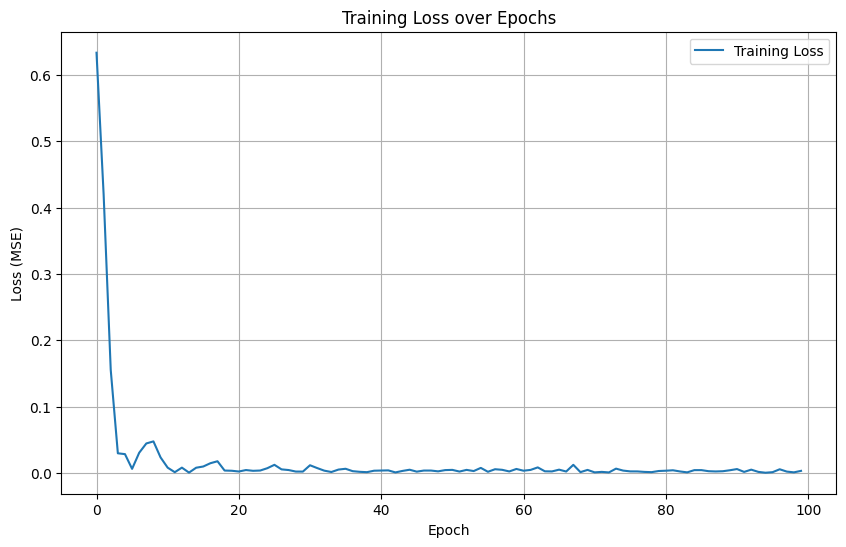

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


## 5. Evaluate and Visualize Predictions

### Evaluate the model on the test set and plot actual vs. predicted prices.

In [71]:

print("\n--- Evaluating Model on Test Set ---")
model.eval()
test_predictions = []
actual_prices = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        test_predictions.extend(outputs.cpu().numpy().flatten())
        actual_prices.extend(batch_y.cpu().numpy().flatten())



--- Evaluating Model on Test Set ---


### Calculate test loss

In [72]:
test_loss = criterion(torch.tensor(test_predictions).to(device), torch.tensor(actual_prices).to(device))
print(f"Test Loss (MSE): {test_loss.item():.6f}")

Test Loss (MSE): 0.000359


### Conevert to NumPy arrays

In [73]:
test_predictions_np = np.array(test_predictions)
actual_prices_np = np.array(actual_prices)

### Inverse transform Predictions

In [74]:
close_col_idx = features_to_scale.index('close')
num_features = len(features_to_scale)
dummy_predictions_array = np.zeros((len(test_predictions_np), num_features))
dummy_predictions_array[:, close_col_idx] = test_predictions_np
original_predictions = scaler.inverse_transform(dummy_predictions_array)[:, close_col_idx]

### Inverse transform actual prices

In [75]:
dummy_actual_array = np.zeros((len(actual_prices_np), num_features))
dummy_actual_array[:, close_col_idx] = actual_prices_np
original_actual_prices = scaler.inverse_transform(dummy_actual_array)[:, close_col_idx]

### Plot Actual vs. Predicted Prices

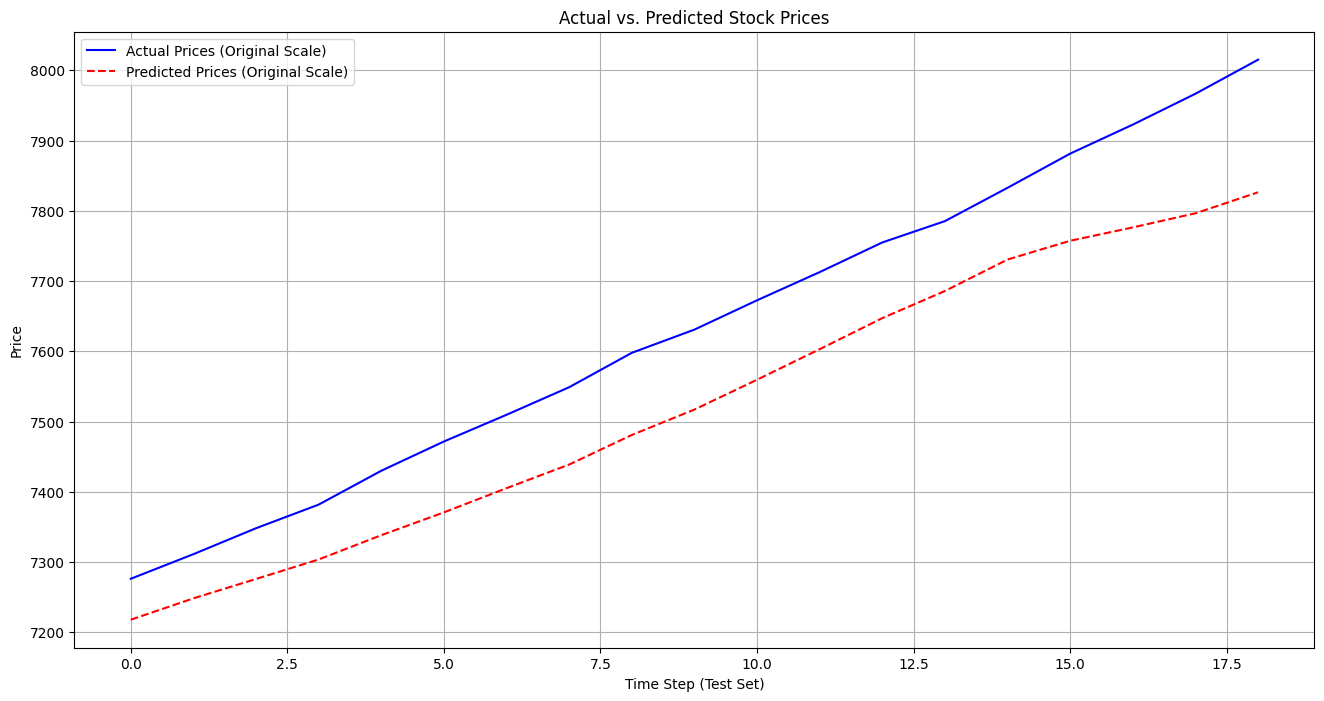

In [76]:
plt.figure(figsize=(16, 8))
plt.plot(original_actual_prices, label='Actual Prices (Original Scale)', color='blue')
plt.plot(original_predictions, label='Predicted Prices (Original Scale)', color='red', linestyle='--')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time Step (Test Set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Plot a smaller segment

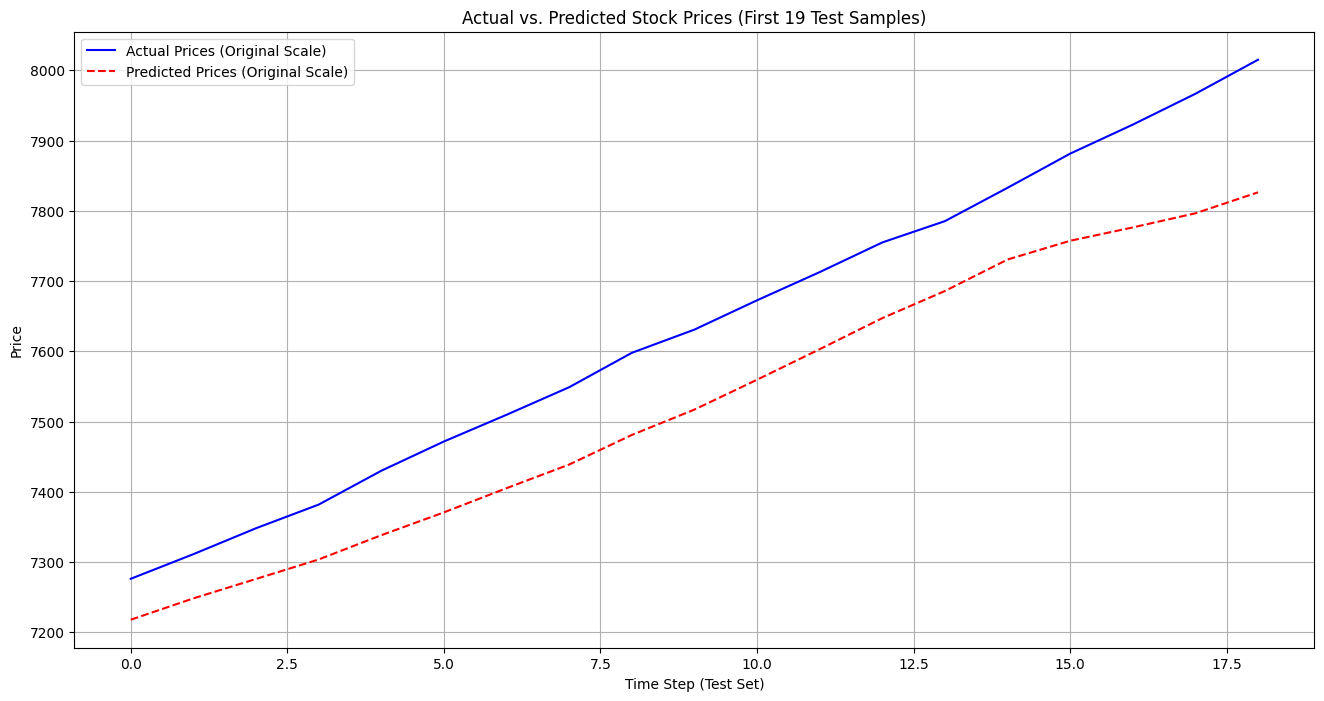

In [77]:
plt.figure(figsize=(16, 8))
plot_start_idx = 0
plot_end_idx = min(100, len(original_actual_prices))
plt.plot(range(plot_end_idx), original_actual_prices[plot_start_idx:plot_end_idx], label='Actual Prices (Original Scale)', color='blue')
plt.plot(range(plot_end_idx), original_predictions[plot_start_idx:plot_end_idx], label='Predicted Prices (Original Scale)', color='red', linestyle='--')
plt.title(f'Actual vs. Predicted Stock Prices (First {plot_end_idx} Test Samples)')
plt.xlabel('Time Step (Test Set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
print("\n--- PyTorch LSTM Training and Evaluation Complete ---")


--- PyTorch LSTM Training and Evaluation Complete ---
